In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import frame as fr
import algo_result as alg_res
import os
from scipy.fft import fft, fftn, fftfreq, fftshift
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import graphviz

%run algo_process.ipynb


In [2]:
def peak_search_dopp(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_strength = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    doppler_details = {"peak_count":0,"total_harmonic_relative_strength":0,"peak_bin":[],"harmonic_relative_strength":[],"max_peak_strength":peak_strength}
    harmonic_strength = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc <= Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            harmonic_strength += pvc[0]
            counter += 1
            doppler_details["peak_bin"].append(fbc)
            doppler_details["harmonic_relative_strength"].append(pvc[0]/peak_strength)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    doppler_details["peak_count"] = counter
    doppler_details["total_harmonic_relative_strength"] = harmonic_strength/peak_strength
    return doppler_details

In [3]:
def doppler_details_extraction(spectrum,T_Lo_thr,T_Mi_thr,T_Hi_thr):
    doppler_details = peak_search_dopp(spectrum,0,np.Inf,0)
    Hi_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    Mi_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    Lo_details={"total_harmonic_relative_strength":0,"peak_count":0,"peak_bin":[],"harmonic_relative_strength":[]}
    for peak_idx in range(doppler_details["peak_count"]):
        if doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Lo_thr and doppler_details["harmonic_relative_strength"][peak_idx] <= 1/T_Mi_thr:
            Lo_details["peak_count"] += 1
            Lo_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Lo_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
        elif doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Mi_thr and doppler_details["harmonic_relative_strength"][peak_idx] <= 1/T_Hi_thr:
            Mi_details["peak_count"] += 1
            Mi_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Mi_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
        elif doppler_details["harmonic_relative_strength"][peak_idx] > 1/T_Hi_thr:
            Hi_details["peak_count"] += 1
            Hi_details["peak_bin"].append(doppler_details["peak_bin"][peak_idx])
            Hi_details["harmonic_relative_strength"].append(doppler_details["harmonic_relative_strength"][peak_idx])
    Lo_details["total_harmonic_relative_strength"] = sum(Lo_details["harmonic_relative_strength"])
    Mi_details["total_harmonic_relative_strength"] = sum(Mi_details["harmonic_relative_strength"])
    Hi_details["total_harmonic_relative_strength"] = sum(Hi_details["harmonic_relative_strength"])
    return Hi_details,Mi_details,Lo_details,doppler_details

In [4]:
SAMPLES_PER_CHIRP = 64
CHIRPS_PER_FRAME = 128
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 512
ANTENNA_SPACING = 6.22e-3

PEAK_THRESHOLD = 0.005 # normalized FFT absolute minimum strength 
PEAK_SLICE = 2 #meters around target
PEAK_WIDTH = 1 #integer
PEAK_RELEVANCE = 0 #minimum distance between pvl1,pvr1 and pvc
SEARCH_ZONE = 25 #split spectrum in slices of SEARCH_ZONE meters to find a single peak
MIN_DIST = 5 #minimum distance for detection

ANGLE_CALIBRATION = -150
ANGLE_PRECISION = 1

ANTENNA_NUMBER = 1

FRAME_REP_INTERVAL = 0.2

   Feature  Importance                    Name
0       f0        1704                location
1       f3        1429                strength
2       f8        1016             correlation
3      f14         976  Mi_skewness_difference
4       f9         962    max_to_mean_distance
5       f1         898                var_dopp
6      f16         884      Side_lobe_strength
7       f6         878           std_deviation
8      f15         811  Hi_skewness_difference
9      f11         782                  SPC_Mi
10      f5         753                  SPC_Lo
11     f18         718         SPC_Mi_variance
12      f4         691                 max_dev
13     f17         602  Side_lobe_max_strength
14     f10         483           Lo_peak_count
15      f7         470  harmonic_power_content
16      f2         449                  SPC_Hi
17     f12         432            Hi_deviation
18     f13         354           Mi_peak_count


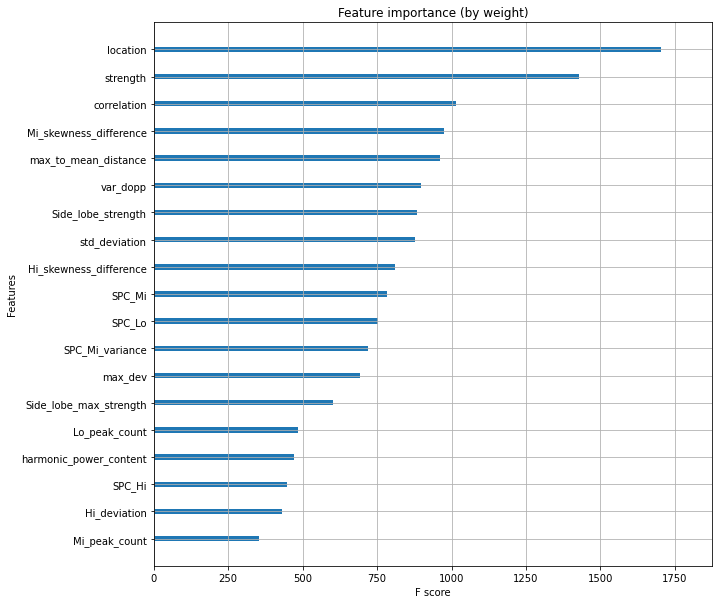

In [5]:
classifier = xgb.XGBClassifier()
classifier.load_model('../statistics_data_processing/code/Trained_stuff/boresight_diagonal_azimuth_model.model')

asd = pd.read_csv("../statistics_data_processing/code/Trained_stuff/Boresight_Diagonal_azimuth.csv",delimiter='\t')
d = asd.to_dict("split")

###Get dictionary with performance for each number of feature
my_dictionary_list = []
for row_idx in range(len(d['data'])):
    for col_idx in range(len(d['columns'])):
        if d['columns'][col_idx] == 'support':
            split_bools = d['data'][row_idx][col_idx] = d['data'][row_idx][col_idx].replace("\n", "").replace("  "," ").replace("[","").replace("]","").split(" ")
            d['data'][row_idx][col_idx] = []
            for elem in split_bools:
                if elem == 'True':
                    d['data'][row_idx][col_idx].append(True)
                elif elem == 'False':
                    d['data'][row_idx][col_idx].append(False)
    best_params= dict(zip(d["columns"],d["data"][row_idx]))
    best_params[d['columns'][col_idx]] = d['data']
    my_dictionary_list.append(best_params)
###Get best performance    
max_score = 0
support = []
feature_names = []
for elem in my_dictionary_list:
    if elem['score'] > max_score:
        max_score = elem['score']
        support = elem['support']
        feature_names = elem['features'].replace("'","").replace('[','').replace(']','').replace('\n','').split(" ")

###Get feature importance
importance_type='weight'
fscores = classifier.get_booster().get_score(importance_type=importance_type)
feat_importances = []
for ft, score in fscores.items():
    feat_importances.append({'Feature': ft, 'Importance': score, 'Name': feature_names[int(ft[1:])]})
feat_importances = pd.DataFrame(feat_importances)
feat_importances = feat_importances.sort_values(
    by='Importance', ascending=False).reset_index(drop=True)
print(feat_importances)
###Sort labels with feature importance
feat_labels = []
for elem in feat_importances.values:
    feat_labels.append(elem[2])
feat_labels = np.flip(feat_labels)
fig,ax = plt.subplots(1,1,figsize=(10,10))

###Plot importance
importance_plot=plot_importance(classifier,ax=ax,importance_type=importance_type,show_values=False)
importance_plot.set_title(f"Feature importance (by {importance_type})")
importance_plot.set_yticklabels(feat_labels)
normalization_factors = pd.read_csv("../statistics_data_processing/code/Trained_stuff/boresight_diagonal_azimuth_norm_factors.csv",delimiter='\t').values
norm_mean = normalization_factors[0]
norm_scale = normalization_factors[1]

In [6]:
#fig,ax = plt.subplots(1,1,figsize=(10,20))
#plot_tree(classifier,ax=ax)
#plt.savefig('Tree',format='png')

In [35]:
directory = '../../data/'

folders = []
#folders.append('Dataset_2')
folders.append('Tire_data')


for folder in folders:
    ###Calibration Data
    calibration_data = pd.read_csv(directory + folder+ '/environment_1.txt', sep='\t', header=None)
    calibration = calibration_data.select_dtypes(include = ['float']).values
    CALIBRATION_FRAME_NUMBER = len(calibration)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
    calibration_frames = []
    ###Create dataset
    for frame in range(CALIBRATION_FRAME_NUMBER):
        calibration_frames.append(fr.Frame(calibration[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                               SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T))

    average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
    for frame in range(1):
        for chirp in range(CHIRPS_PER_FRAME):
            average_calib_chirp += calibration_frames[frame].get_chirp(chirp)

    average_calib_chirp /= CHIRPS_PER_FRAME
    
    ###Target Data
    
    data_directory = os.fsencode(directory + folder + '/')

    for file in os.listdir(data_directory):
        filename = os.fsdecode(file)
        if filename.find('environment') == -1 and filename.endswith('.txt') and filename.find('No_PCB_backwards_1') != -1:
            actual_filename = filename
            path = os.path.join(os.fsdecode(data_directory), filename)
            print(path)                    
            data = pd.read_csv(path, sep='\t', header=None)
            data.columns = ["idx","I_RX1","Q_RX1"]

            recording = data.select_dtypes(include = ['float']).values
            FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
            Hu_bi_frame = []
            ###Create dataset
            for frame in range(FRAME_NUMBER):
                Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                                       SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)) 
            ###Calibrate frames
            calibrate = True
            if calibrate:
                for frame in range(FRAME_NUMBER):
                    Hu_bi_frame[frame].calibrate(average_calib_chirp)

            xf = np.arange(0,RANGE_PAD)
            range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
            range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
            vel_bin = fftshift(fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL))*SPEED_OF_LIGHT/(2*START_FREQUENCY) 

            Target_observations = []
            Range_spectrum_history = []
            Unfiltered_spectrum_history = []
            Target_info_list = []
            Target_presence_list = []

            ###Process frames
            for frame in range(FRAME_NUMBER):
                data_out,target_info, MTI_out = algo_process(Hu_bi_frame[frame],RANGE_PAD,CHIRPS_PER_FRAME,DOPPLER_PAD,PEAK_THRESHOLD,PEAK_SLICE,PEAK_WIDTH,PEAK_RELEVANCE,SEARCH_ZONE,ANGLE_CALIBRATION,ANGLE_PRECISION,round(LAMBDA/ANTENNA_SPACING),range2bin)
                Range_spectrum_history.append(MTI_out)
                Unfiltered_spectrum_history.append(abs(data_out[:,0,0]))
                if(target_info.num_targets > 0 and target_info.location[0] < SEARCH_ZONE and target_info.location[0] > MIN_DIST):
                    Target_info_list.append(target_info)
                    Target_presence_list.append(1)
                else:
                    Target_presence_list.append(0)  

            ###Feature extraction
            target_doppler_spec = np.zeros((DOPPLER_PAD,1))
            idx = 0

            weighted_avg = []
            weighted_std = []
            location = []
            strength = []
            dB_Hi = 15
            T_Hi_thr = np.power(10,dB_Hi/20)
            dB_Mi = 30
            T_Mi_thr = np.power(10,dB_Mi/20)
            dB_Lo = 44
            T_Lo_thr = np.power(10,dB_Lo/20)
            SPC_Hi = []
            SPD = []
            SPC_Lo = []
            SPC_Mi = []
            MDR = []
            maximum_deviation = []
            Hi_peak_count = []
            Lo_peak_count = []
            std_deviation = []
            Hi_harmonic_power_content = []
            Lo_harmonic_power_content = []
            frame_counter = []
            correlation = []
            max_to_mean_distance = []
            peak_strength_std = []
            Lo_skewness = []
            Lo_skewness_variation = []
            Hi_deviation = []
            Hi_deviation_difference = []
            Mi_peak_count = []
            Mi_harmonic_power_content = []
            Mi_skewness = []
            Mi_skewness_difference = []
            Hi_skewness = []
            Hi_skewness_difference = []
            Lo_skewness_mean = []
            Side_lobe_strength = []
            Side_lobe_max_spread = []
            SPC_Lo_skewness = []
            SPC_Mi_Hi_skewness = []
            SPC_Mi_variance = []
            counter = 0
            
            
            
            all_features = [location,weighted_avg,weighted_std,SPC_Hi,SPD,MDR,strength,maximum_deviation,SPC_Lo,Hi_peak_count,\
                           std_deviation,Hi_harmonic_power_content,frame_counter,correlation,max_to_mean_distance,peak_strength_std,\
                           Lo_peak_count,Lo_harmonic_power_content,SPC_Mi,Lo_skewness,Lo_skewness_variation,Hi_deviation,\
                           Hi_deviation_difference, Mi_peak_count, Mi_harmonic_power_content, Mi_skewness, Mi_skewness_difference,\
                           Hi_skewness, Hi_skewness_difference,Lo_skewness_mean,Side_lobe_strength,Side_lobe_max_spread,SPC_Lo_skewness,\
                           SPC_Mi_Hi_skewness, SPC_Mi_variance]

            mask = []
            kk = 0
            for u in range(len(all_features)):
                if u == 1:
                    mask.append(False)
                elif u == 12:
                    mask.append(False)
                elif u == 15:
                    mask.append(False)
                else:
                    mask.append(support[kk])
                    kk+=1
            
            predictions = []
            
            
            bi_quadratic = []
            for i in range(DOPPLER_PAD):
                if i > 3*DOPPLER_PAD//8 and i < DOPPLER_PAD//2:
                    bi_quadratic.append(1-(i-7*DOPPLER_PAD//16)**2/(DOPPLER_PAD//16)**2)
                elif i > DOPPLER_PAD//2 and i < 5*DOPPLER_PAD//8:
                    bi_quadratic.append(1-(i-9*DOPPLER_PAD//16)**2/(DOPPLER_PAD//16)**2)
                else:
                    bi_quadratic.append(0)
                    
            hor_quadratic = []
            for i in range(DOPPLER_PAD):
                if i > DOPPLER_PAD//4 and i < DOPPLER_PAD//2:
                    hor_quadratic.append(np.sqrt((DOPPLER_PAD//2-i)/(DOPPLER_PAD//4)))
                elif i > DOPPLER_PAD//2 and i < 3*DOPPLER_PAD//4:
                    hor_quadratic.append(np.sqrt((i-DOPPLER_PAD//2)/(DOPPLER_PAD//4)))
                else:
                    hor_quadratic.append(0) 
            
            previous_target_presence = 1 #to check for targets present in 2 subsequent frames
            no_interruption = 0
            subsequent_frames = 0

            for target_presence in Target_presence_list:
                counter +=1
                ###Use to cut pieces of recording
                if folder == 'Dataset_1':
                    if filename.find('driving_diagonal_1')!=-1:
                        if counter > 145 and counter < 275:
                            target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
                            continue
                    elif filename.find('driving_diagonal_2')!=-1:
                        if counter > 135 and counter < 195:
                            target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
                            continue
                    elif filename.find('driving_diagonal_3')!=-1:
                        if counter > 135 and counter < 260:
                            target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)
                            continue
                if target_presence:
                    next_dopp_spectrum = Target_info_list[idx].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1))*Target_info_list[idx].location[0]**2
                    target_doppler_spec = np.append(target_doppler_spec,next_dopp_spectrum , axis=1)
                    if previous_target_presence:
                        ###
                        location.append(Target_info_list[idx].location[0]/SEARCH_ZONE)
                        strength.append(sum(next_dopp_spectrum))
                        ###
                        length = len(next_dopp_spectrum)
                        max_peak = max(next_dopp_spectrum)
                        SPC_Hi_thresh = max_peak/T_Hi_thr
                        SPC_Mi_thresh = max_peak/T_Mi_thr
                        SPC_Lo_thresh = max_peak/T_Lo_thr
                        weighted_avg.append(sum([i*next_dopp_spectrum[i] for i in range(length)])/sum(next_dopp_spectrum[:]))
                        tmp_roll = np.roll(next_dopp_spectrum,DOPPLER_PAD//2-round(weighted_avg[subsequent_frames][0]))
                        weighted_std.append(np.sqrt(sum([(i-DOPPLER_PAD//2)**2*tmp_roll[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])/(DOPPLER_PAD//4)**2))
                        ###
                        max_peak_bin = np.argmax(next_dopp_spectrum)
                        tmp_roll = np.roll(next_dopp_spectrum,DOPPLER_PAD//2-max_peak_bin)
                        SPC_Hi.append(sum([tmp_roll[i] > SPC_Hi_thresh for i in range(length)])/DOPPLER_PAD)
                        if(not no_interruption):
                            SPC_prime = SPC_Hi[subsequent_frames-1]
                        else:
                            previous_doppler_spectrum = Target_info_list[idx-1].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1))*Target_info_list[idx-1].location[0]**2
                            SPC_prime = sum([previous_doppler_spectrum[i] > SPC_Hi_thresh for i in range(length)])/DOPPLER_PAD
                        SPD.append(np.abs(SPC_Hi[subsequent_frames] - SPC_Hi[subsequent_frames-1]))
                        SPC_Lo.append(sum([(tmp_roll[i] > SPC_Lo_thresh and tmp_roll[i] <= SPC_Mi_thresh) for i in range(length)])/DOPPLER_PAD)
                        SPC_Lo_skewness.append(sum([int(tmp_roll[i] > SPC_Lo_thresh and tmp_roll[i] <= SPC_Mi_thresh)*tmp_roll[i]*(i-DOPPLER_PAD//2)**3 for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/(DOPPLER_PAD//4)**3/np.max(tmp_roll))
                        SPC_Mi.append(sum([(tmp_roll[i] > SPC_Mi_thresh and tmp_roll[i] <= SPC_Hi_thresh) for i in range(length)])/DOPPLER_PAD)
                        SPC_Mi_Hi_skewness.append(sum([int(tmp_roll[i] > SPC_Mi_thresh)*tmp_roll[i]*(i-DOPPLER_PAD//2)**3 for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/(DOPPLER_PAD//4)**3/np.max(tmp_roll))
                        SPC_Mi_variance.append(sum([int(tmp_roll[i] > SPC_Mi_thresh and tmp_roll[i] <= SPC_Hi_thresh)*tmp_roll[i]*(i-DOPPLER_PAD//2)**2 for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/(DOPPLER_PAD//4)**2/np.max(tmp_roll))
                        Gt = np.max(Target_info_list[idx].doppler_spectrum[:,0])*Target_info_list[idx].location[0]**2
                        Gt_prime = np.max(Target_info_list[idx-1].doppler_spectrum[:,0])*Target_info_list[idx-1].location[0]**2
                        MDR.append(np.abs(Gt - Gt_prime)/Gt )
                        
                        ### Details extraction
                        Hi_details,Mi_details,Lo_details,all_details = doppler_details_extraction(tmp_roll,T_Lo_thr,T_Mi_thr,T_Hi_thr)                        
                        if(not no_interruption):
                            previous_doppler_spectrum = Target_info_list[idx-1].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1))*Target_info_list[idx-1].location[0]**2
                            max_peak_bin_prime = np.argmax(previous_doppler_spectrum)
                            tmp_roll_prime = np.roll(previous_doppler_spectrum,DOPPLER_PAD//2-max_peak_bin_prime)
                            Hi_details_prime,Mi_details_prime,Lo_details_prime,all_details_prime = doppler_details_extraction(tmp_roll_prime,T_Lo_thr,T_Mi_thr,T_Hi_thr)

                        maximum_deviation.append(np.sqrt(sum([(i-DOPPLER_PAD//2)**2*tmp_roll[i] for i in range(length)])/sum(next_dopp_spectrum[:])/DOPPLER_PAD**2))
                        Side_lobe_strength.append(np.sqrt(sum([bi_quadratic[i]*tmp_roll[i] for i in range(length)])/sum(next_dopp_spectrum[:])))
                        Side_lobe_max_spread.append(np.sqrt(sum([hor_quadratic[i]*tmp_roll[i] for i in range(length)])/sum(next_dopp_spectrum[:])))
                        ###High

                        Hi_peak_count.append(Hi_details["peak_count"])
                        Hi_harmonic_power_content.append(Hi_details["total_harmonic_relative_strength"])
                        hi_std = np.sqrt(sum([(Hi_details["peak_bin"][i]-DOPPLER_PAD//2)**2*Hi_details["harmonic_relative_strength"][i] for i in range(Hi_details["peak_count"])])/(DOPPLER_PAD//2)**2)
                        Hi_deviation.append(hi_std)
                        Hi_deviation_difference.append(abs(Hi_deviation[subsequent_frames] - Hi_deviation[subsequent_frames-1]))
                        third_moment = (sum([(Hi_details["peak_bin"][i]-DOPPLER_PAD//2)**3*Hi_details["harmonic_relative_strength"][i] for i in range(Hi_details["peak_count"])])/(DOPPLER_PAD//2)**3)
                        Hi_skewness.append(third_moment)
                        
                        if(no_interruption):
                            Hi_skewness_prime = Hi_skewness[subsequent_frames-1]
                        else:
                            Hi_skewness_prime = (sum([(Hi_details_prime["peak_bin"][i]-DOPPLER_PAD//2)**3*Hi_details_prime["harmonic_relative_strength"][i] for i in range(Hi_details_prime["peak_count"])])/(DOPPLER_PAD//2)**3)
                        
                        Hi_skewness_difference.append(abs(Hi_skewness[subsequent_frames] - Hi_skewness_prime))
                        
                        ###Mid

                        Mi_peak_count.append(Mi_details["peak_count"])
                        Mi_harmonic_power_content.append(Mi_details["total_harmonic_relative_strength"])
                        third_moment = (sum([(Mi_details["peak_bin"][i]-DOPPLER_PAD//2)**3*Mi_details["harmonic_relative_strength"][i] for i in range(Mi_details["peak_count"])])/(DOPPLER_PAD//2)**3)
                        Mi_skewness.append(third_moment)
                        if(no_interruption):
                            Mi_skewness_prime = Mi_skewness[subsequent_frames-1]
                        else:
                            Mi_skewness_prime = (sum([(Mi_details_prime["peak_bin"][i]-DOPPLER_PAD//2)**3*Mi_details_prime["harmonic_relative_strength"][i] for i in range(Mi_details_prime["peak_count"])])/(DOPPLER_PAD//2)**3)

                        Mi_skewness_difference.append(abs(Mi_skewness[subsequent_frames] - Mi_skewness_prime))
                        
                        ###Low

                        Lo_peak_count.append(Lo_details["peak_count"])
                        Lo_harmonic_power_content.append(Lo_details["total_harmonic_relative_strength"])
                        skewness = (sum([(Lo_details["peak_bin"][i]-DOPPLER_PAD//2)**3*Lo_details["harmonic_relative_strength"][i] for i in range(Lo_details["peak_count"])])/(DOPPLER_PAD//2)**3)
                        Lo_skewness.append(skewness)
                        if(no_interruption):
                            Lo_skewness_prime = Lo_skewness[subsequent_frames-1]
                        else:
                            Lo_skewness_prime = (sum([(Lo_details_prime["peak_bin"][i]-DOPPLER_PAD//2)**3*Lo_details_prime["harmonic_relative_strength"][i] for i in range(Lo_details_prime["peak_count"])])/(DOPPLER_PAD//2)**3)

                        Lo_skewness_variation.append(abs(Lo_skewness[subsequent_frames] - Lo_skewness_prime))
                        Lo_skewness_mean.append((Lo_skewness[subsequent_frames] + Lo_skewness_prime)/2)
                        
                        ###
                        if(no_interruption):
                            weighted_std_prime = weighted_std[subsequent_frames-1]
                        else:
                            previous_doppler_spectrum = Target_info_list[idx-1].doppler_spectrum[:,0].reshape((DOPPLER_PAD,1))*Target_info_list[idx-1].location[0]**2
                            weighted_avg_prime = (sum([i*previous_doppler_spectrum[i] for i in range(length)])/sum(previous_doppler_spectrum[:]))
                            tmp_roll = np.roll(previous_doppler_spectrum,DOPPLER_PAD//2-round(weighted_avg_prime[0]))
                            weighted_std_prime = (np.sqrt(sum([(i-DOPPLER_PAD//2)**2*tmp_roll[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])/(DOPPLER_PAD//4)**2))


                        
                        std_deviation.append(np.abs(weighted_std[subsequent_frames] - weighted_std_prime))
                        frame_counter.append(counter)
                        ###
                        correlation.append(sum(Target_info_list[idx].doppler_spectrum[:,0]*Target_info_list[idx-1].doppler_spectrum[:,0])/sum(Target_info_list[idx].doppler_spectrum[:,0])**2)
                        ###
                        max_to_mean_distance.append(np.abs(max_peak_bin-weighted_avg[subsequent_frames])/DOPPLER_PAD)
                        ###
                        peak_strength = np.max(Target_info_list[idx].print[:,:,0],axis=0)*Target_info_list[idx].location[0]**2
                        peak_strength_mean = np.sum(peak_strength)/CHIRPS_PER_FRAME
                        peak_strength_std.append(np.sqrt(np.sum((peak_strength-peak_strength_mean)**2)))
                        
                        
                        ### Prediction
                        X_test = []
                        for v in range(len(mask)):
                            if mask[v]:
                                try:
                                    X_test.append(all_features[v][subsequent_frames][0])
                                except:
                                    X_test.append(all_features[v][subsequent_frames])
                        X_test = (np.array(X_test) - np.array(norm_mean[support]))/np.array(norm_scale[support]).reshape(1,-1)  
                        predictions.append(classifier.predict(X_test)[0])        

                        subsequent_frames += 1
                        
                    ### Append -1 in case 2 subsequent frames were not available    
                    else:
                        predictions.append(-1)
                    idx += 1
                else:
                    predictions.append(-1)
                    target_doppler_spec = np.append(target_doppler_spec, np.zeros((DOPPLER_PAD,1)), axis=1)

                no_interruption = previous_target_presence
                previous_target_presence = target_presence
                no_interruption = no_interruption and previous_target_presence and target_presence

            target_doppler_spec = target_doppler_spec[:,1:]
            print("Doppler x total_frames: " + str(target_doppler_spec.shape))
            ### SAVE STATS
            '''
            Target_statistics = np.empty((1,subsequent_frames))
            for feature in all_features:
                Target_statistics = np.append(Target_statistics,np.array(feature).reshape(1,-1),axis=0)
            Target_statistics = Target_statistics[1:,:]


            print("Extracted_features x data_points: " + str(Target_statistics.shape))

            df = pd.DataFrame(Target_statistics)
            output_path = "../statistics_data_processing/data/"
            output_filename = actual_filename.split('.')[0]
            extension = '_statistics'
            df.T.to_csv(output_path+output_filename+'_'+folder+extension+'.txt', sep='\t',index=False, header=False)
            '''

../../data/Tire_data/No_PCB_backwards_1.txt
Doppler x total_frames: (512, 200)


In [36]:
predictions_converted = []
for pred in predictions:
    if pred == 0 or pred == 3 or pred == 6:
        predictions_converted.append(0)
    elif pred == 1 or pred == 4 or pred == 7:
        predictions_converted.append(1)
    elif pred == 2 or pred == 5 or pred == 8:
        predictions_converted.append(2)
    elif pred == -1:
        predictions_converted.append(-1)
predictions = predictions_converted
print(predictions)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


<ipython-input-38-72f59c880ea9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


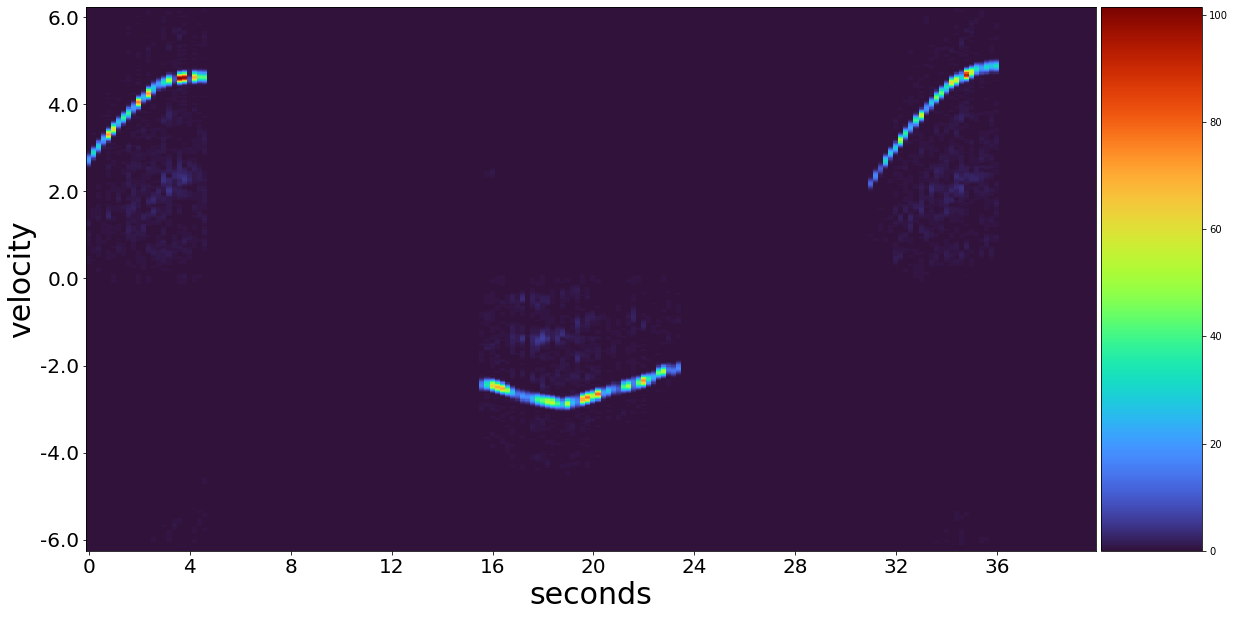

In [38]:
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
### PLOT DOPPLER VS TIME
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(target_doppler_spec))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(target_doppler_spec), 100)
ax.pcolormesh(np.arange(0,counter)*FRAME_REP_INTERVAL,vel_bin,target_doppler_spec, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('velocity', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
plt.savefig('Thesis_figures/'+'No_PCB.png')
            

<ipython-input-18-3a5077f1ffce>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


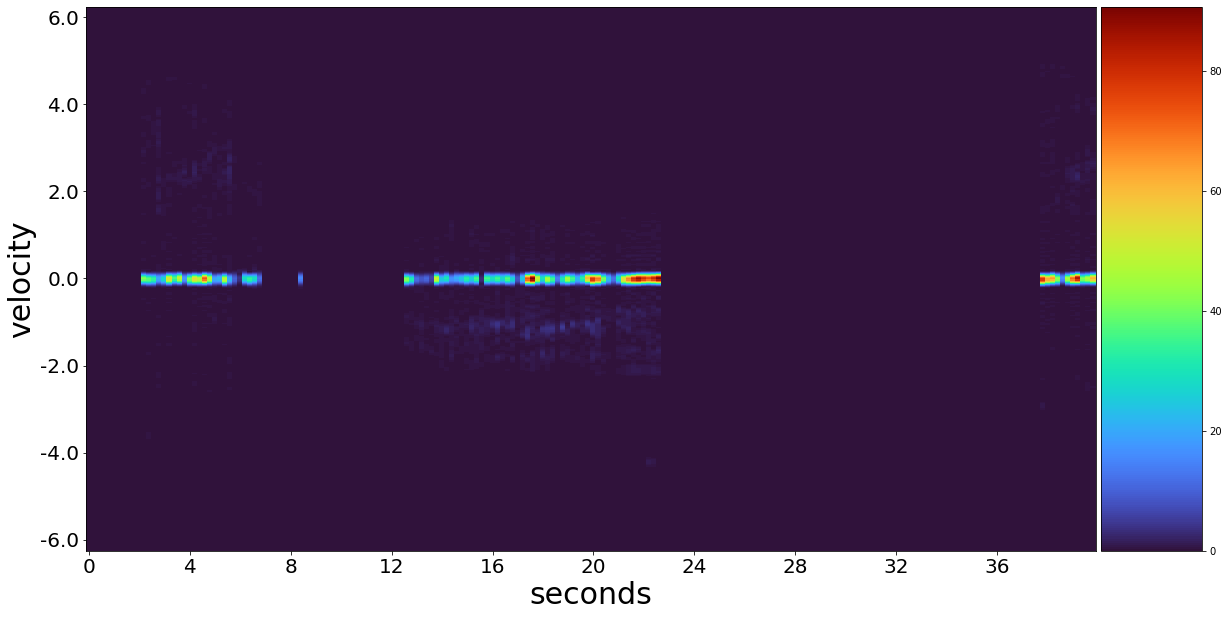

In [18]:
%matplotlib inline
rolled_doppler = np.zeros(target_doppler_spec.shape)

for frame in range(FRAME_NUMBER):
    if max(target_doppler_spec[:,frame]) > 0:
        max_idx = np.argmax(target_doppler_spec[:,frame])
        #round(sum([(i)*target_doppler_spec[i,frame] for i in range(DOPPLER_PAD)])/sum(target_doppler_spec[:,frame]))
        rolled_doppler[:,frame] = np.roll(target_doppler_spec[:,frame],(DOPPLER_PAD//2 - max_idx))

fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(rolled_doppler))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(rolled_doppler), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,vel_bin,rolled_doppler, cmap=cmap, norm=norm, shading='nearest')
#ax.contourf(np.arange(0,FRAME_NUMBER),vel_bin,rolled_doppler, levels, cmap=cmap, norm=norm)
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('velocity', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
#plt.savefig('Thesis_figures/'+'centered_all_doppler_biking_boresight_1.png')

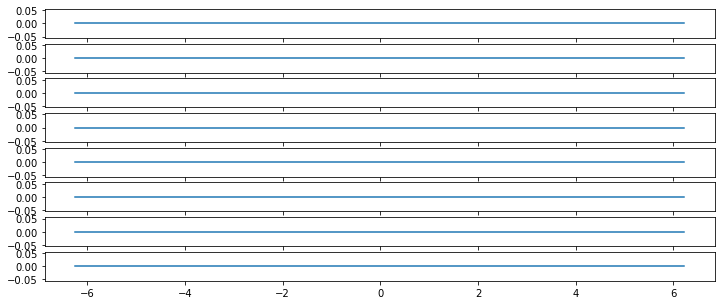

In [11]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[12,5])
from_second_number = 100#round(32/FRAME_REP_INTERVAL)
for col in range(column_plots):
    for row in range(row_plots):
        data = target_doppler_spec[:,row + row_plots*col + from_second_number].reshape((1,-1))[0,:]
        ax[row].plot(vel_bin,data)
plt.show()

In [12]:
%matplotlib widget
fig,ax = plt.subplots(3,1, figsize=[12,5]) 
from_second_number = 105#round(32/FRAME_REP_INTERVAL)+5
#for frame in np.arange(from_second_number,from_second_number+1):
ax[0].plot(np.sum(target_doppler_spec[:,from_second_number:from_second_number+1],axis=1))
if(sum(target_doppler_spec[:,from_second_number:from_second_number+1][:] > 0)):
    actual_dopp = target_doppler_spec[:,from_second_number:from_second_number+1]
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[0].plot(weighted_avg_1,np.max(actual_dopp),'ro')
    low_tresh = np.max(actual_dopp)/T_Lo_thr*np.ones(length)
    mid_tresh = np.max(actual_dopp)/T_Mi_thr*np.ones(length)
    high_tresh = np.max(actual_dopp)/T_Hi_thr*np.ones(length)
    ax[0].plot(low_tresh)
    ax[0].plot(mid_tresh)
    ax[0].plot(high_tresh)
    ax[0].set_ylim((0,high_tresh[0]*11/10))


    actual_dopp = np.roll(actual_dopp,DOPPLER_PAD//2 - round(weighted_avg_1[0]))
    ax[1].plot(actual_dopp)
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax[1].plot(DOPPLER_PAD//2,np.max(actual_dopp),'ro')
    ax[1].plot(low_tresh)
    ax[1].plot(mid_tresh)
    ax[1].plot(high_tresh)

    weighted_std_1 = ([(i-DOPPLER_PAD//2)**2*actual_dopp[i] for i in np.arange(DOPPLER_PAD//4,3*DOPPLER_PAD//4)])/sum(tmp_roll[DOPPLER_PAD//4:3*DOPPLER_PAD//4])/(DOPPLER_PAD//4)**2
    ax[2].plot(np.arange(0,len(weighted_std_1))+DOPPLER_PAD//4,weighted_std_1,'bo')
    print(np.sqrt(sum(weighted_std_1)))
    print(round(weighted_avg_1[0]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

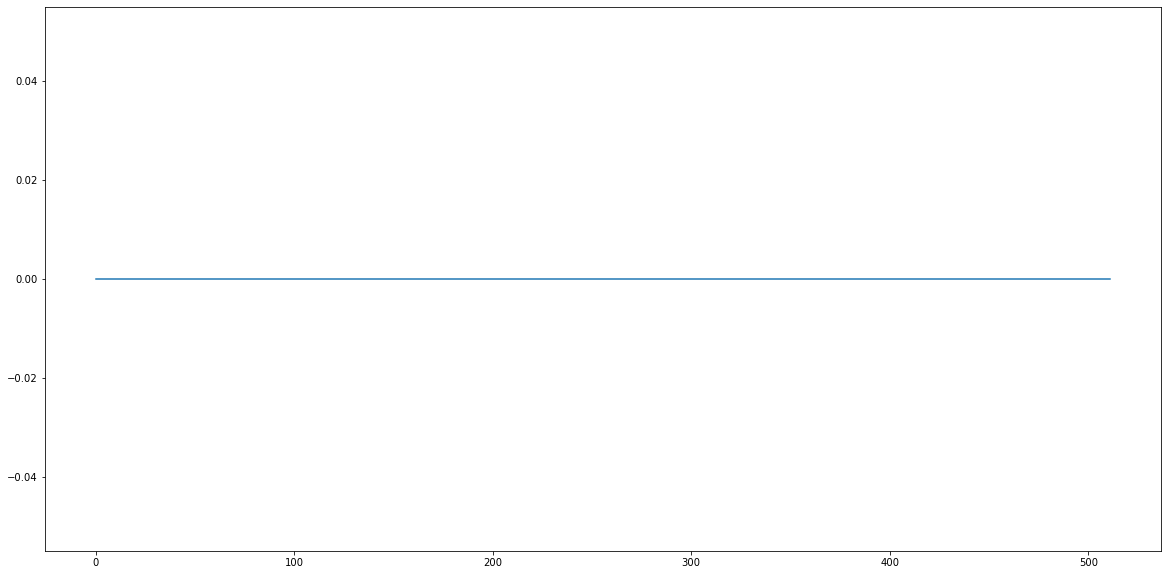

In [13]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(np.sum(target_doppler_spec[:,from_second_number:from_second_number+1],axis=1))
if(sum(target_doppler_spec[:,from_second_number:from_second_number+1][:] > 0)):
    actual_dopp = target_doppler_spec[:,from_second_number:from_second_number+1]
    weighted_avg_1 = sum([i*actual_dopp[i] for i in range(length)])/sum(actual_dopp[:])
    ax.plot(weighted_avg_1,np.max(actual_dopp),'ro')
    low_tresh = np.max(actual_dopp)/T_Lo_thr*np.ones(length)
    mid_tresh = np.max(actual_dopp)/T_Mi_thr*np.ones(length)
    high_tresh = np.max(actual_dopp)/T_Hi_thr*np.ones(length)
    ax.plot(low_tresh)
    ax.plot(mid_tresh)
    ax.plot(high_tresh)
    #ax.set_ylim((0,high_tresh[0]*11/10))

In [14]:
def peak_search_details(spectrum,Lo_thresh,Hi_thresh,peak_relevance):
    counter = 0
    peak_power = np.max(spectrum)
    peak_bin = np.argmax(spectrum)
    harmonic_power = 0
    fbc = 2
    fbl2 = fbc - 2
    fbl1 = fbc - 1
    fbr1 = fbc + 1
    fbr2 = fbc + 2
    peak_info = {"peak_bin":[],"peak_strength":[],"max_peak_strength":peak_power}
    
    for idx in range(len(spectrum)):
        if fbr2 >= len(spectrum):
            continue
        pvl2 = spectrum[fbl2]
        pvl1 = spectrum[fbl1]
        pvc = spectrum[fbc]
        pvr1 = spectrum[fbr1]
        pvr2 = spectrum[fbr2]
        if pvl2+peak_relevance < pvl1 and pvr1 > pvr2+peak_relevance and pvc > Lo_thresh and pvc < Hi_thresh and pvc >= pvl1 and pvc >= pvr1 and fbc != peak_bin:
            peak_info["peak_bin"].append(fbc)
            peak_info["peak_strength"].append(pvc/peak_power)
        fbc += 1
        fbl2 = fbc - 2
        fbl1 = fbc - 1
        fbr1 = fbc + 1
        fbr2 = fbc + 2
    return peak_info
    

In [15]:
frame_doppler_peaks_dict = []
for target in Target_info_list:
    max_bin = np.argmax(target.doppler_spectrum[:,0])
    frame_doppler_peaks_dict.append(peak_search_details(np.roll(target.doppler_spectrum[:,0]*target.location[0]**2,DOPPLER_PAD//2 - max_bin),0,np.Inf,0))

In [16]:
%matplotlib widget
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
all_doppler_peaks = np.array([])
for frame in frame_doppler_peaks_dict:
    all_doppler_peaks = np.append(all_doppler_peaks,np.array(frame["peak_strength"]))
n,bins=np.histogram(all_doppler_peaks,5000)
cumulative_n = [0]
for idx in range(len(n)):
    cumulative_n.append(n[idx] + cumulative_n[idx])
ax.plot(bins,cumulative_n/cumulative_n[-1])
ax.set_xlim((0,0.8))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 0.8)

In [17]:
peak_presence_frequency = np.zeros(len(bins)-1)
for frame_peaks in frame_doppler_peaks_dict:
    for bin_idx in range(len(bins)-1):
        for peak in frame_peaks['peak_strength']:
            if bins[bin_idx] <= peak and bins[bin_idx+1] >= peak:
                peak_presence_frequency[bin_idx] += 1
                break               
    

fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list))
                

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
fig,ax = plt.subplots(1,1, figsize=[12,5]) 
ax.plot(bins[:-1],peak_presence_frequency/sum(Target_presence_list)**2*n)
ax.set_xlim((0,0.04))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.0, 0.04)

In [19]:
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Range_spectrum_history))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(Range_spectrum_history), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,range_bin,np.array(Range_spectrum_history).T, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('range', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
plt.savefig('Thesis_figures/'+'Presentation_MTI_range_driving_boresight_1.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-19-f607c31a32bd>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


In [20]:
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1],'wspace':0.01}, figsize=[20,10])
ax.clear()
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Unfiltered_spectrum_history))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
levels = np.linspace(0.0, np.max(Unfiltered_spectrum_history), 100)
ax.pcolormesh(np.arange(0,FRAME_NUMBER)*FRAME_REP_INTERVAL,range_bin,np.array(Unfiltered_spectrum_history).T, cmap=cmap, norm=norm, shading='nearest')
ax.set_xlabel('seconds',fontsize=30)
ax.set_ylabel('range', fontsize=30)
_ = ax.set_xticks(np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL)
_ = ax.set_xticklabels((np.arange(0,FRAME_NUMBER,20)*FRAME_REP_INTERVAL).astype('int'),fontsize=20)
#_ = ax.set_yticks(vel_bin[np.arange(0,DOPPLER_PAD,64)])
_ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)
#plt.savefig('Thesis_figures/'+'Unfiltered_range_biking_boresight_1.png')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-20-d2be87e60bd3>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels(ax.get_yticks(),fontsize=20)


In [21]:
%matplotlib widget
column_plots = 1
row_plots = 2
fig,ax = plt.subplots(row_plots,column_plots,figsize=[12,5])
from_second_number = 0
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = Target_info_list[row + row_plots*col + from_second_number].print[:,:,0].T.reshape((1,-1))[0,:]
        ax[row].set_ylim(0,0.2)
        ax[row].plot(data)
        ax[row].plot(separator_list[:],'ro',markersize=0.5)
plt.show()

peak_avg = sum(np.max(Target_info_list[from_second_number].print[:,:,0],axis=0))/CHIRPS_PER_FRAME

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
column_plots = 1
row_plots = 8
fig,ax = plt.subplots(row_plots,column_plots,figsize=[20,10])
from_second_number = 9
separator = np.zeros(len(Target_info_list[0].print[:,0,0]))
separator[-1] = 0.05
separator_list = []
for i in range(len(Target_info_list[0].print[0,:,0])):
    separator_list.append(separator)
separator_list = np.array(separator_list).reshape((1,-1))[0,:]

for col in range(column_plots):
    for row in range(row_plots):
        data = np.max(Target_info_list[row + row_plots*col + from_second_number].print[:,:,0],axis=0).T.reshape((1,-1))[0,:]
        ax[row].hist(data,bins=100,range=(0,0.2),density=False)
plt.show()
print(Target_info_list[from_second_number].location[0])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

11.377206099784633


In [23]:
peak_collection = []
for target in Target_info_list:
    peak_strength = np.max(target.print[:,:,0],axis=0)*target.location[0]**2
    peak_strength_mean = np.sum(peak_strength)/CHIRPS_PER_FRAME
    peak_collection.append(peak_strength-peak_strength_mean)
peak_collection = np.array(peak_collection).reshape((1,-1))
_=plt.hist(peak_collection[0,:],bins=100)

In [24]:
'''
from matplotlib.animation import FuncAnimation, writers
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(25, 25))

classes = ['Pedestrian','Cyclist','Car']

ax1.title.set_text('Range')
ax1.title.set_fontsize(40)
ax2.title.set_fontsize(40)
ax2.title.set_text('Doppler')

ax1.set_xlim(range_bin[0], range_bin[-1])
ax1.set_ylim(0,np.max(Range_spectrum_history)*8/10)
ax2.set_xlim(vel_bin[0], vel_bin[-1])
ax1.tick_params(labelsize=30)
ax2.tick_params(labelsize=30)
#ax2.set_ylim(0,np.max(target_doppler_spec)*0.5)
ax1.axvline(MIN_DIST, lw=3, linestyle='--', color='black')
ax1.axvline(SEARCH_ZONE, lw=3, linestyle='--', color='black', label='Search Region')
ax1.plot(range_bin,np.ones(len(range_bin))*PEAK_THRESHOLD, lw=3, linestyle='dotted', color='gray', label='Detection Threshold')
# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], lw=4, color='r', label='Filtered Range FFT Spectrum')
line2, = ax2.plot([], [], lw=4, color='r', label='Doppler FFT Spectrum')
line11, = ax1.plot([], [], 'D', color='black', markersize=15,label='Target location')
line21, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen', label='Feature Extractor')
line22, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen')
line23, = ax2.plot([],[], lw=3, linestyle='dashdot',color='limegreen')
line24, = ax2.plot([],[], lw=3, linestyle='dashdot',color='royalblue', label='Feature Extractor')
line25, = ax2.plot([],[], lw=3, linestyle='dashdot',color='royalblue')
line = [line1, line2, line21,line22,line23,line24,line25, line11]
ax1.legend(fontsize=20,loc=1)
ax2.legend(fontsize=20,loc=1)
#plt.xlabel(r'meters')
#plt.ylabel(r'fft magnitude')
text_axis = ax2.text(.2, -.2, 'Class:'+'No prediction available', style='italic',fontsize=60,
        bbox={'facecolor': 'bisque', 'alpha': 0.5, 'pad': 10},visible=True,transform=ax2.transAxes)
#
# animation function
def animate(i):
    line[0].set_data(range_bin, Range_spectrum_history[i])
    if predictions[i] == -1:
        text_axis.set_text('Class:'+'No prediction available')
    elif predictions[i] == 0:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    elif predictions[i] == 1:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    elif predictions[i] == 2:
        text_axis.set_text('Class:'+classes[predictions[i]] + ' at ' + str(round(range_bin[np.argmax(Range_spectrum_history[i])],2))+ ' m')
    if(Target_presence_list[i]>0):
        #ax1.set_ylim(0,np.max(Range_spectrum_history[i]*11/10))
        ax2.set_ylim(0,np.max(target_doppler_spec[:,i])*11/10)
        line[1].set_data(vel_bin,target_doppler_spec[:,i])
        line[2].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Lo_thr)
        line[3].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Mi_thr)
        line[4].set_data(vel_bin,np.ones(DOPPLER_PAD)*np.max(target_doppler_spec[:,i])/T_Hi_thr)
        line[5].set_data(vel_bin,np.roll(np.array(bi_quadratic)*np.max(target_doppler_spec[:,i]),np.argmax(target_doppler_spec[:,i])-DOPPLER_PAD//2))
        line[6].set_data(vel_bin,np.roll(np.array(hor_quadratic)*np.max(target_doppler_spec[:,i]),np.argmax(target_doppler_spec[:,i])-DOPPLER_PAD//2))
        line[7].set_data(range_bin[np.argmax(Range_spectrum_history[i])],np.max(Range_spectrum_history[i]))
    else:
        for i in np.arange(1,8):
            line[i].set_data([],[])
    return line

anim = FuncAnimation(fig, animate, frames=FRAME_NUMBER)
Writer = writers['ffmpeg']
writer = Writer(fps=1/(FRAME_REP_INTERVAL), metadata={'artist':'Me'}, bitrate=3600)

anim.save('../../videos/'+folder+'_'+actual_filename + '_complete_model' +'.mp4',writer)
'''

"\nfrom matplotlib.animation import FuncAnimation, writers\nfig,[ax1,ax2] = plt.subplots(2,1,figsize=(25, 25))\n\nclasses = ['Pedestrian','Cyclist','Car']\n\nax1.title.set_text('Range')\nax1.title.set_fontsize(40)\nax2.title.set_fontsize(40)\nax2.title.set_text('Doppler')\n\nax1.set_xlim(range_bin[0], range_bin[-1])\nax1.set_ylim(0,np.max(Range_spectrum_history)*8/10)\nax2.set_xlim(vel_bin[0], vel_bin[-1])\nax1.tick_params(labelsize=30)\nax2.tick_params(labelsize=30)\n#ax2.set_ylim(0,np.max(target_doppler_spec)*0.5)\nax1.axvline(MIN_DIST, lw=3, linestyle='--', color='black')\nax1.axvline(SEARCH_ZONE, lw=3, linestyle='--', color='black', label='Search Region')\nax1.plot(range_bin,np.ones(len(range_bin))*PEAK_THRESHOLD, lw=3, linestyle='dotted', color='gray', label='Detection Threshold')\n# intialize two line objects (one in each axes)\nline1, = ax1.plot([], [], lw=4, color='r', label='Filtered Range FFT Spectrum')\nline2, = ax2.plot([], [], lw=4, color='r', label='Doppler FFT Spectrum')

In [25]:
print(len(Range_spectrum_history[0]))

256


In [26]:
print(Target_presence_list)

[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
